In [4]:
import numpy as np
import scipy as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import squareform
from itertools import product

plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 200
sns.set(context='poster',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})
sns.set_context('notebook')

%load_ext autoreload
%autoreload 2

dev = 'cuda'
root = '/home/ubuntu/ext_vol'
import sys
sys.path.insert(0, f'{root}/inpca')

from utils import get_data, get_idx, plot_pairwise_dist, plot_dendrogram
from utils.embed import proj_
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.express as px
from bokeh import palettes
import matplotlib.colors as mcolors

pyo.init_notebook_mode()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array):

    pdist = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pdist, method='complete', optimal_ordering=True)
    distance_threshold = pdist.max()/2
    cluster = sch.fcluster(linkage, distance_threshold, 
                           criterion='distance')
    idx = np.argsort(cluster)
    corr_array = corr_array.copy()
    if isinstance(corr_array, pd.DataFrame):
        return cluster, corr_array.iloc[idx, :].T.iloc[idx, :]
    return linkage, cluster, corr_array[idx, :][:, idx]

In [6]:
from utils import CDICT_M, CDICT_OPT
import matplotlib.colors as mcolors

cdict_opt ={m: mcolors.to_rgba(c) for (m, c) in CDICT_OPT.items()}
cdict_m ={m: mcolors.to_rgba(c) for (m, c) in CDICT_M.items()}

### Clustering using original checkpoints (skip)

In [ ]:
import h5py
r = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_all_geod.p")
didx = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all.p").reset_index(drop=True)
didx = didx.drop('index', axis=1)

f = h5py.File('/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yh_all_geod.h5', 'r')
w = f['w']
ii = get_idx(didx, "err > 0.5 & err < 0.52")
wi = w[ii, :][:, ii]
di = didx.iloc[ii].reset_index(drop=True)

In [ ]:
idx=di.groupby(cols).indices

In [ ]:
pdists = np.zeros([len(idx), len(idx)])
keys = list(idx.keys())
for i in range(len(idx)):
    for j in range(i, len(idx)):
        ii = idx[keys[i]]
        jj = idx[keys[j]]
        pdists[i, j] = pdists[j, i] = wi[ii, :][:, jj].mean()

In [ ]:
fig, ax = plt.subplots(figsize =(8, 16))
linkage, cluster, sorted_dists = cluster_corr(pdists)
dend = sch.dendrogram(linkage, orientation='right', no_plot=True, color_threshold=2)
for c in cols:
    di[c] = di[c].astype(str)
cs = di.iloc[dend['leaves'][::-1]][cols].apply('.'.join, axis=1)
dend = sch.dendrogram(linkage, orientation='right', labels=np.array(cs), color_threshold=2)
for x in ax.get_ymajorticklabels():
    x.set_color(cdict[x.get_text().split('.')[label_by]])

### Load Data

In [9]:
key = 'yh'
cols = ['m', 'opt', 'bs', 'lr', 'wd', 'aug']

# remove avg models
dists = th.load(f'{root}/inpca/inpca_results_avg_new/dists_3d_{key}.p')
didx = th.load(f'{root}/inpca/inpca_results_avg_new/didx_3d_{key}.p').reset_index(drop=True)

In [10]:
non_avg = get_idx(didx, "seed >= -1")
didx = didx.iloc[non_avg].reset_index(drop=True)
dists = dists[:, :, non_avg][:, non_avg, :]

In [11]:
trained = didx[didx.err <= 0.1].index
didx = didx.iloc[trained].reset_index(drop=True)
dists = dists[:, :, trained][:, trained, :]

### Dendrograms

In [14]:
idx=didx.groupby(cols).indices
pdists = np.zeros([100, len(idx), len(idx)])
keys = list(idx.keys())
for i in range(len(idx)):
    for j in range(i, len(idx)):
        ii = idx[keys[i]]
        jj = idx[keys[j]]
        dij = dists[:, ii, :][:, :, jj]
#         assert np.allclose(dists[:, jj, :][:,:,ii], dij.transpose(0,2,1))
        pdists[:, i, j] = pdists[:, j, i] = dij.mean(axis=(1,2)) 

In [15]:
rows = columns = np.array(keys, dtype="O")

In [53]:
t = 90
# avg_pdists = pdists[:t, :, :].sum(0)/100
avg_pdists = pdists[t, :, :]
np.fill_diagonal(avg_pdists, 0)
v = squareform(avg_pdists)
# v = sch.distance.pdist(avg_pdists)

linkage = sch.linkage(v, method='complete', optimal_ordering=True)
cs = ['-'.join(str(l)) for l in columns.astype(str)]
rs = ['-'.join(str(l)) for l in rows.astype(str)]

In [17]:
didx=didx.rename(columns={"err_interp": "err", "verr_interp": "verr"})

In [18]:
didx.loc[didx['aug'] == 'simple', 'aug'] = 'aug'

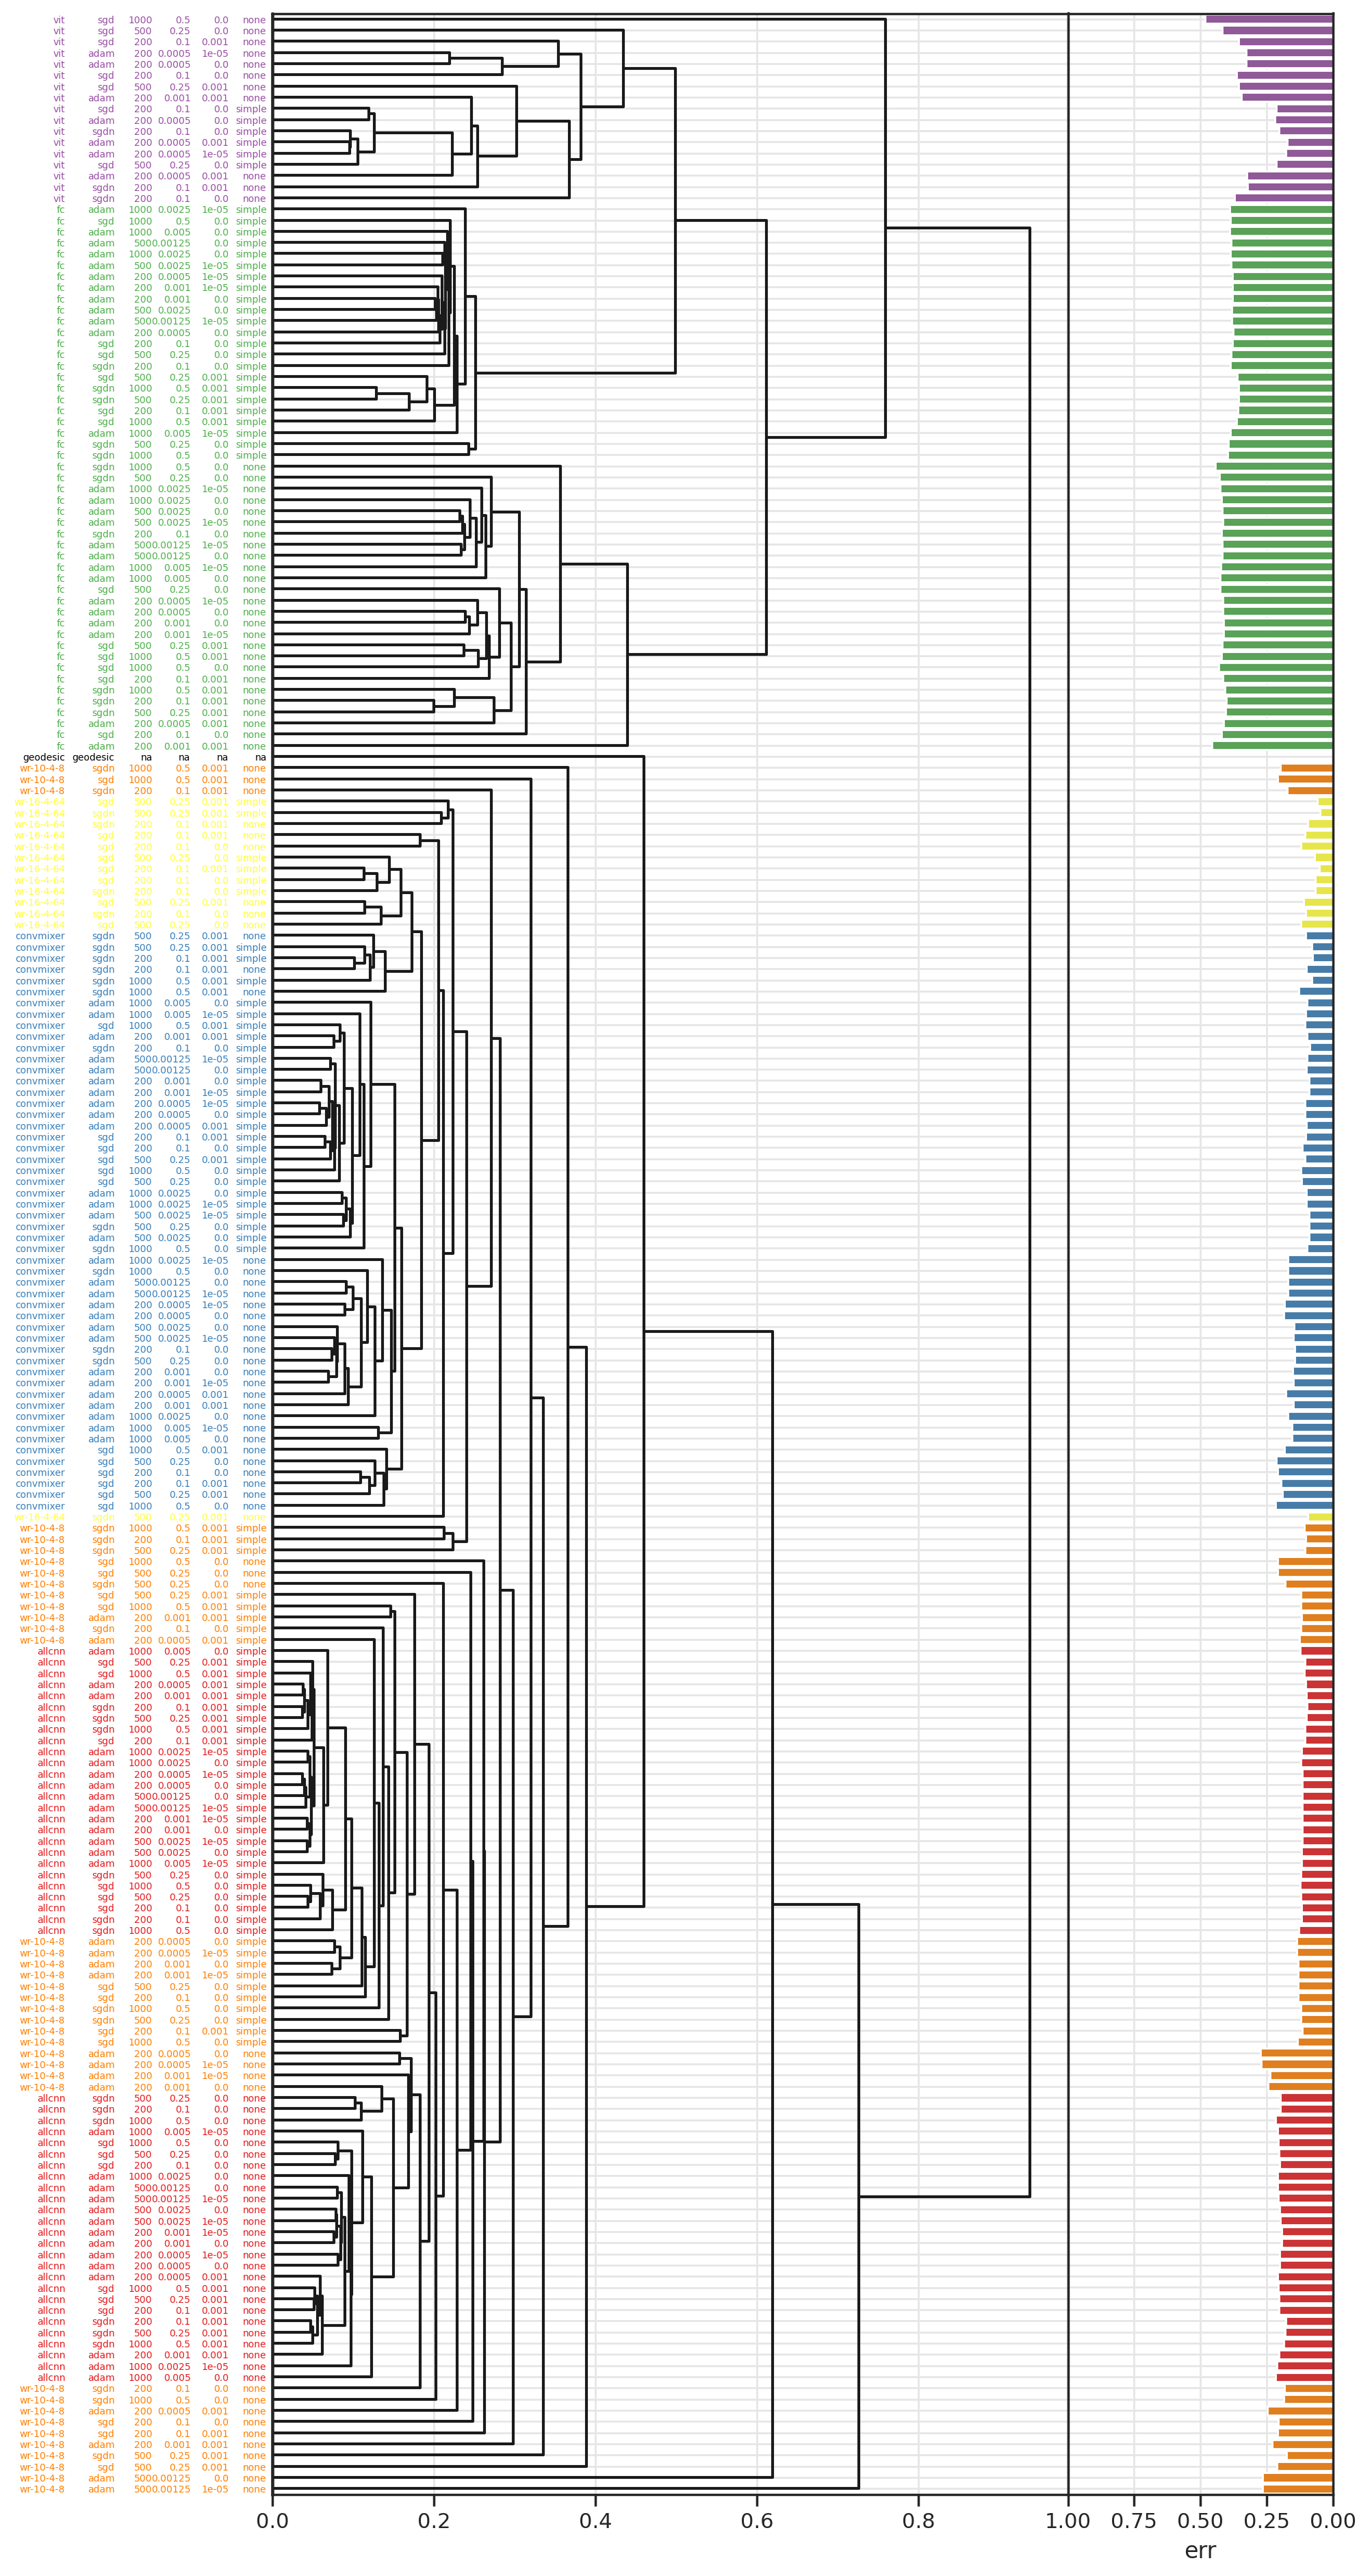

In [54]:
ig = np.where(columns[:, 0] == 'geodesic')[0]
fig, dend=plot_dendrogram(linkage, columns,  didx=didx, key=key,
#                      color_threshold=0,
                    above_threshold_color='k',
                      cdict=cdict_m,
                      cols=cols,
                      color_by=0,
#                       color_threshold=linkage[np.where(linkage[:, :2]==ig)[0],2])
                          color_threshold=0)

In [35]:
fig.savefig(f'plots/{key}_dend_{t}.pdf', bbox_inches='tight')  

### Distance to mean

In [12]:
all_d = pd.DataFrame()
for (c, ii) in didx.groupby(cols).indices.items():
    avg_ii = ii[-1]
    m_ii = ii[:-1]
    d2avg = dists[:, m_ii, avg_ii]
    df = pd.DataFrame(d2avg)
    df['t'] = list(np.linspace(0,1,100))
    df = df.melt(id_vars='t')
    df['config'] =  [tuple(c) for i in range(len(df))]
    all_d = pd.concat([all_d, df])

In [13]:
for (i, c) in enumerate(cols):
    all_d[c] = np.stack(all_d.config)[:, i]

In [21]:
dd=np.stack([np.diag(pdists[i, :, :]) for i in range(100)])

In [34]:
davg = pd.DataFrame()
for i in range(100):
    di = pd.DataFrame(np.diag(pdists[i, :, :]), columns=['davg'])
    di['t'] = i
    davg = pd.concat([davg, di])

[(-0.01, 0.2)]

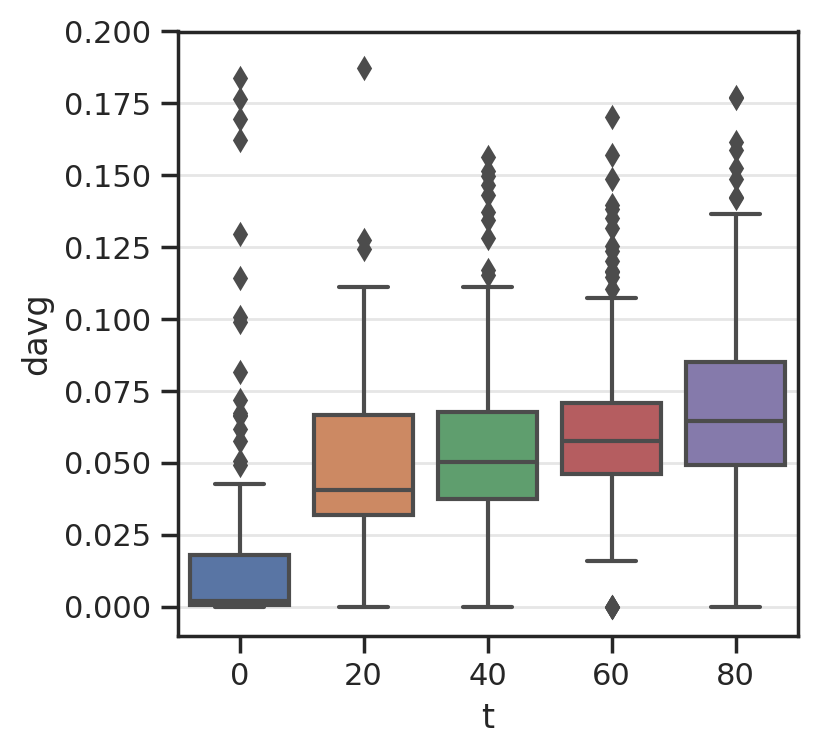

In [41]:
ax=sns.boxplot(data=davg[davg.t.isin(davg.t.unique()[::20])].reset_index(), x='t', y='davg')
ax.set(ylim=(-0.01, 0.2))

ValueError: AxesSubplot(0.125,0.125;0.775x0.755) has no legend attached.

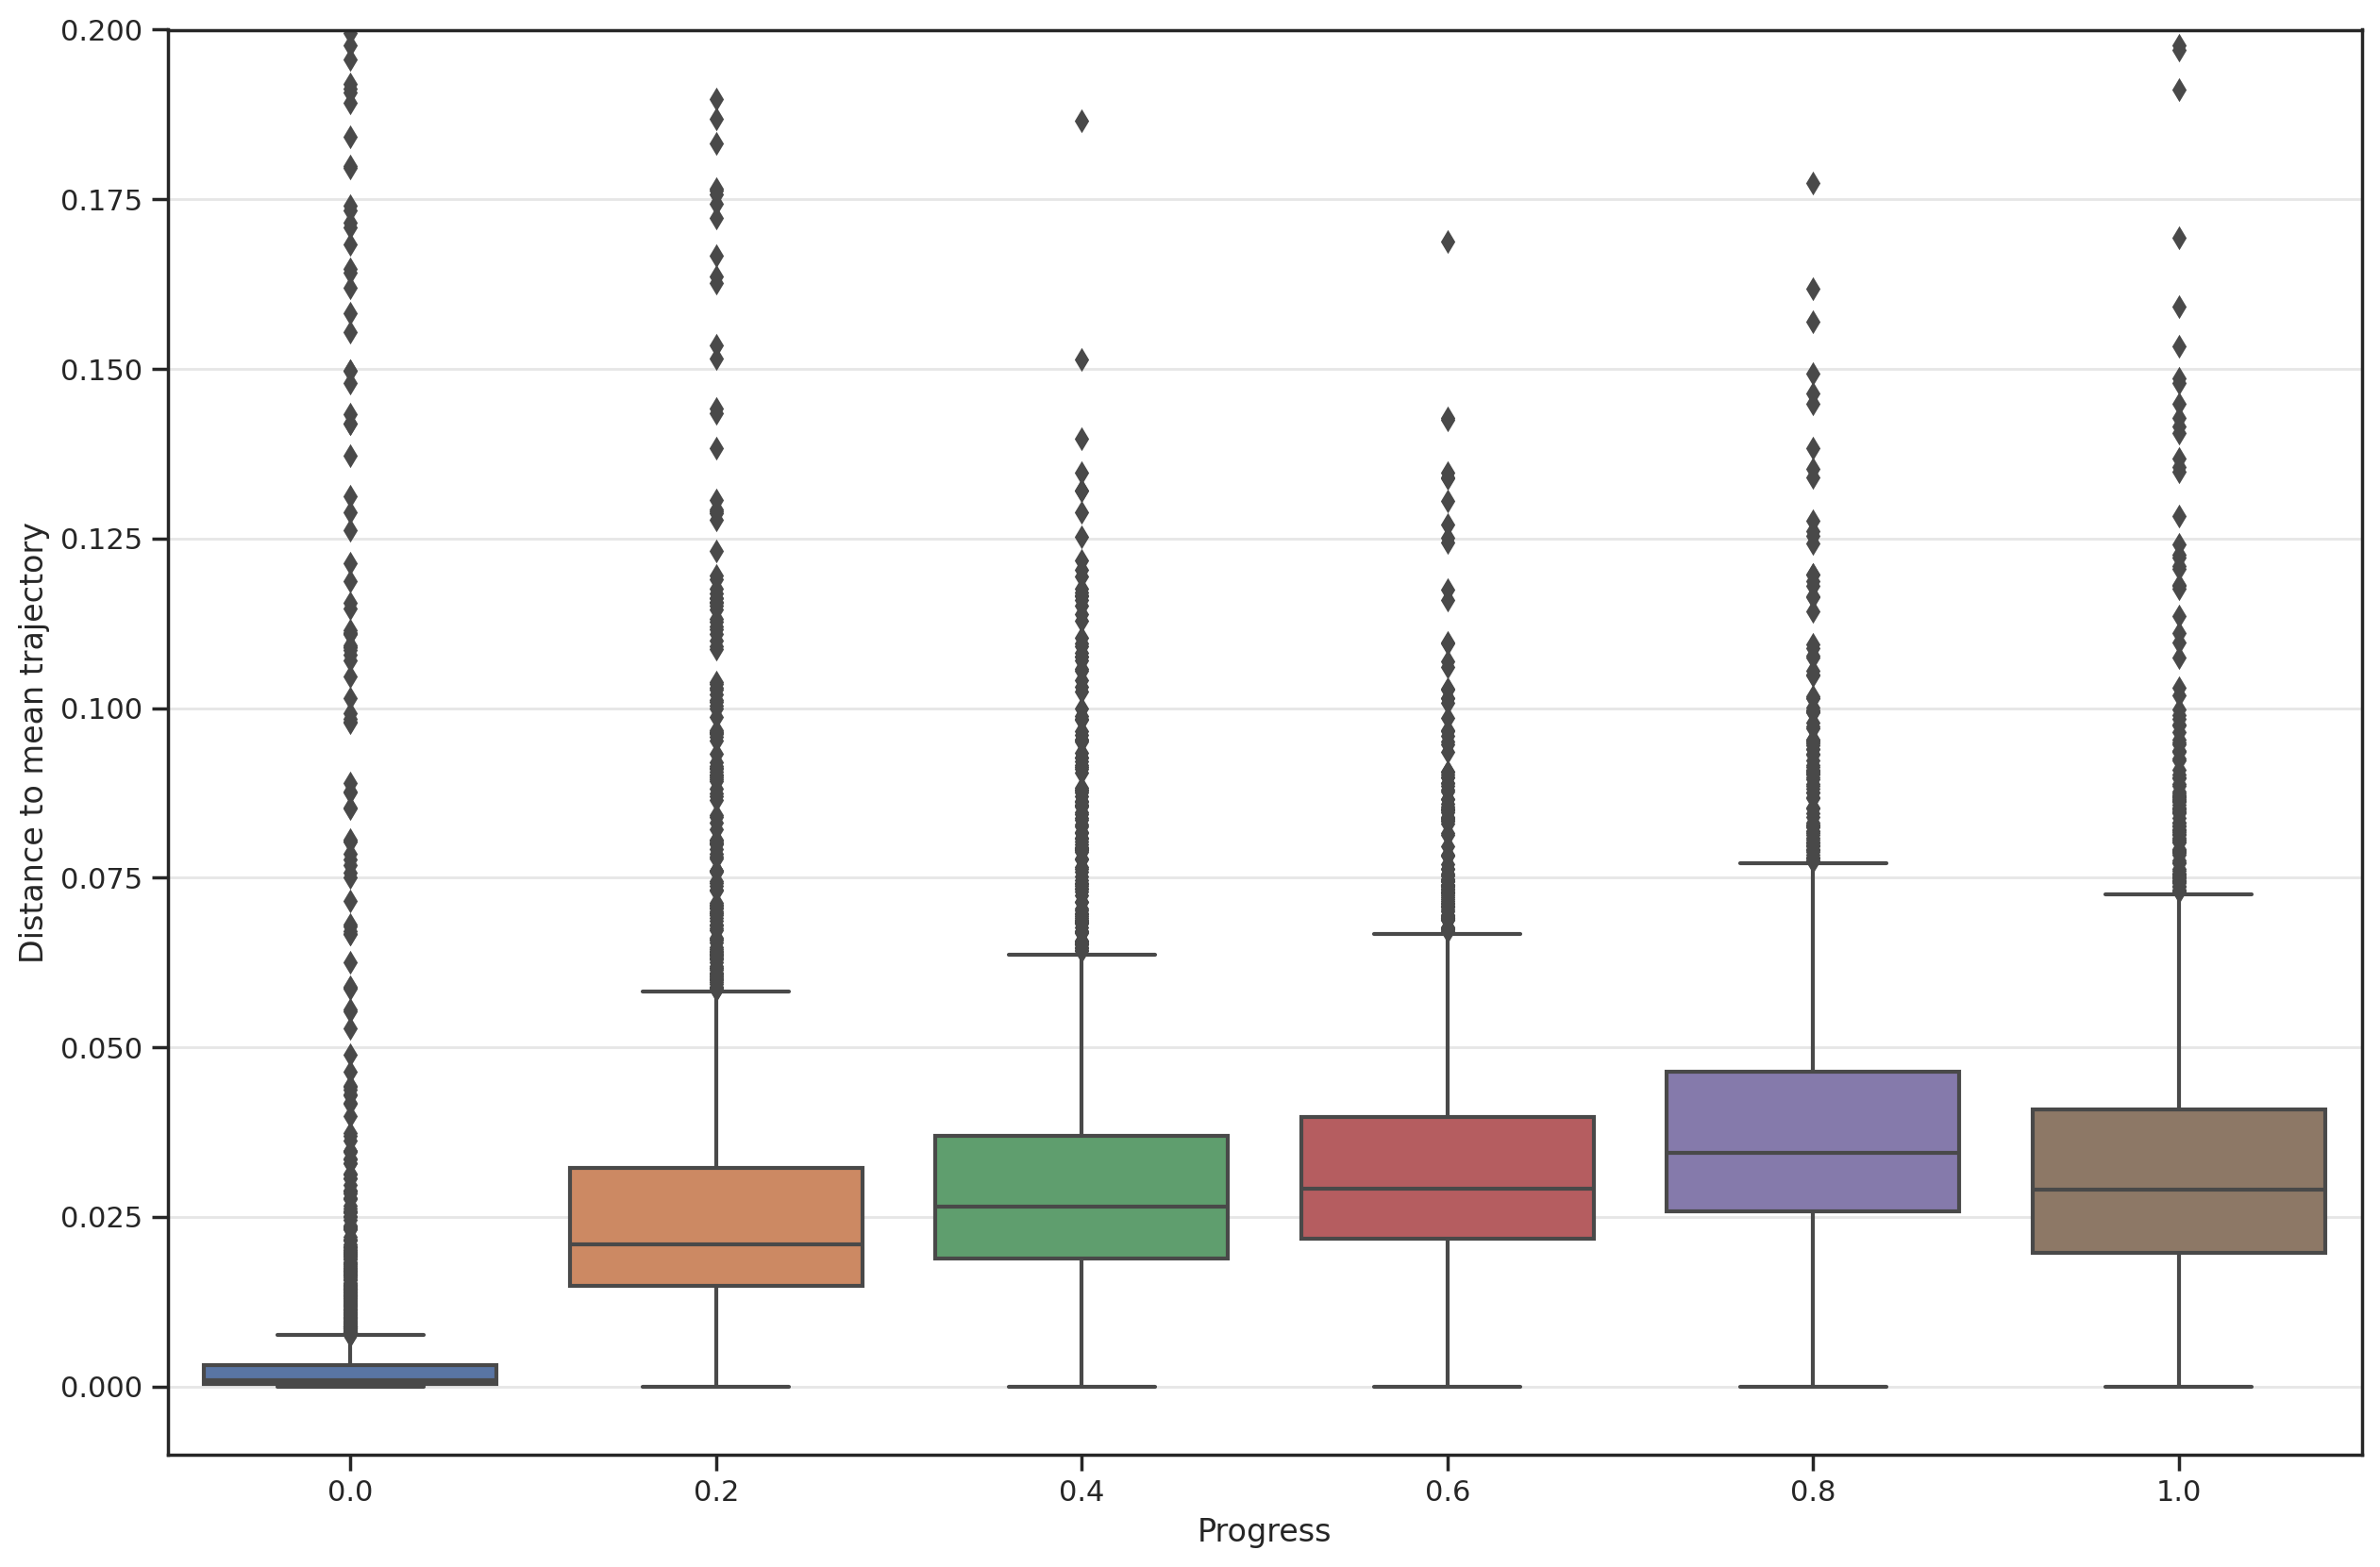

In [44]:
f, ax = plt.subplots(figsize=(15,10))
# di = all_d[all_d.m == 'fc'].reset_index()
ax=sns.boxplot(data=all_d[all_d.t.isin(all_d.t.unique()[::19])].reset_index(), x='t', y='value')
ax.set(ylabel='Distance to mean trajectory')
ax.set(xlabel='Progress')
ticks = [i.get_text() for i in ax.get_xticklabels()]
# new_ticks = ['-'.join(new_ticks[i:i+2]) for i in range(len(new_ticks)-1)] + ['>150']
ticks = ax.set_xticks(np.arange(0, len(ticks)),all_d.t.unique()[::19].round(1))
ax.set(ylim=(-0.01, 0.2))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
i = 49
f, ax = plt.subplots()
ax=sns.box(data=all_d.iloc[0:44100].reset_index(), x='t', y='value', hue='config', style='aug')
ax.set(ylabel='Distance to mean trajectory')
ax.set(xlabel='Progress')
# ticks = [i.get_text() for i in ax.get_xticklabels()]
# new_ticks = ['-'.join(new_ticks[i:i+2]) for i in range(len(new_ticks)-1)] + ['>150']
# ticks = ax.set_xticks(np.arange(0, len(ticks)),all_d.t.unique()[::i].round(1))
# ax.set(xlabel=)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

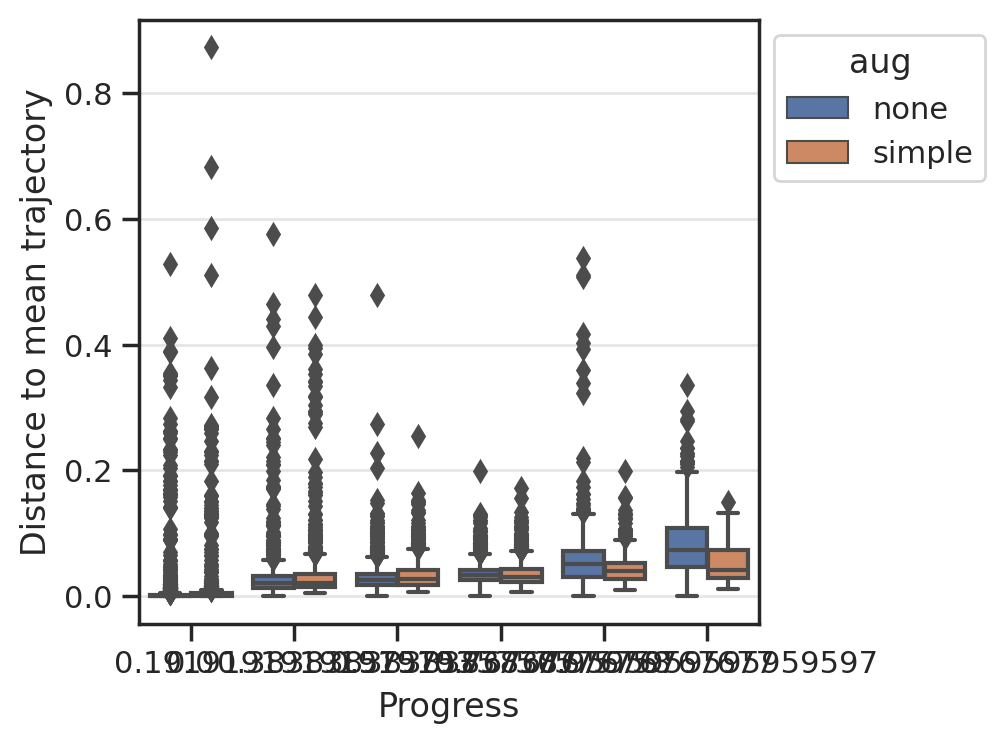

In [97]:
i = 19
f, ax = plt.subplots()
ax=sns.boxplot(data=all_d[all_d.t.isin(all_d.t.unique()[::i])].reset_index(), x='t', y='value', hue='aug')
# ax=sns.lineplot(data=all_d[all_d.t.isin(all_d.t.unique()[::i])].reset_index(), x='t', y='value', hue='m', style='aug')
ax.set(ylabel='Distance to mean trajectory')
ax.set(xlabel='Progress')
# ticks = [i.get_text() for i in ax.get_xticklabels()]
# # new_ticks = ['-'.join(new_ticks[i:i+2]) for i in range(len(new_ticks)-1)] + ['>150']
# ticks = ax.set_xticks(np.arange(0, len(ticks)),all_d.t.unique()[::i].round(1))
# ax.set(yscale='log')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [83]:
all_d

t variable  value                                        config  \
0     0.000000        0    0.0        (allcnn, adam, 200, 0.0005, 0.0, none)   
1     0.010101        0    0.0        (allcnn, adam, 200, 0.0005, 0.0, none)   
2     0.020202        0    0.0        (allcnn, adam, 200, 0.0005, 0.0, none)   
3     0.030303        0    0.0        (allcnn, adam, 200, 0.0005, 0.0, none)   
4     0.040404        0    0.0        (allcnn, adam, 200, 0.0005, 0.0, none)   
...        ...      ...    ...                                           ...   
1095  0.959596       10    0.0  (wr-16-4-64, sgdn, 500, 0.25, 0.001, simple)   
1096  0.969697       10    0.0  (wr-16-4-64, sgdn, 500, 0.25, 0.001, simple)   
1097  0.979798       10    0.0  (wr-16-4-64, sgdn, 500, 0.25, 0.001, simple)   
1098  0.989899       10    0.0  (wr-16-4-64, sgdn, 500, 0.25, 0.001, simple)   
1099  1.000000       10    0.0  (wr-16-4-64, sgdn, 500, 0.25, 0.001, simple)   

               m   opt   bs      lr     wd     aug  
0         allcnn  adam  200  0.0005    0.0    none  
1         allcnn  adam  200  0.0005    0.0    none  
2         allcnn  adam  200  0.0005    0.0    none  
3         allcnn  adam  200  0.0005    0.0    none  
4         allcnn  adam  200  0.0005    0.0    none  
...          ...   ...  ...     ...    ...     ...  
1095  wr-16-4-64  sgdn  500    0.25  0.001  simple  
1096  wr-16-4-64  sgdn  500    0.25  0.001  simple  
1097  wr-16-4-64  sgdn  500    0.25  0.001  simple  
1098  wr-16-4-64  sgdn  500    0.25  0.001  simple  
1099  wr-16-4-64  sgdn  500    0.25  0.001  simple  

[238200 rows x 10 columns]

### InPCA at fixed progress

In [11]:
def get_explained_var(r, key='yh'):
    ii = np.argsort(np.abs(r['es']))[::-1]
    es = r['es'][ii][:50]
    dset = 'train' if key == 'yh' else 'test'
    df = pd.DataFrame({'eigenvalue index':np.arange(len(es)), 'explained variance':1 - np.sqrt(1-np.cumsum(es ** 2)/r['fn']**2), 
                       'data':dset})
    return df

In [12]:
from embed import proj_
import scipy.sparse.linalg as sp

exp_v = []
t = 100
# for t in tqdm.tqdm(range(100)):
w = dists[:t, :, :].sum(0)/100
# w = dists[t, :, :]

weight = np.ones(len(w))
iw = get_idx(didx, "m=='geodesic'")
# weight[iw] = len(didx)//10
weight /= weight.sum()

dmean = (w*weight).sum(1, keepdims=True)
w = w- dmean
w = w- (w*weight[:, None]).sum(0)
w = -0.5*w
r = proj_(w, w.shape[0], 3)

ne = 50
es, vs = sp.eigsh(w, ne, which='LM', return_eigenvectors=True)
r['es'] = es
r['fn'] = np.linalg.norm(w, 'fro')
df = get_explained_var(r, 'yvh')
exp_v.append( df.iloc[3]['explained variance'])


Projecting


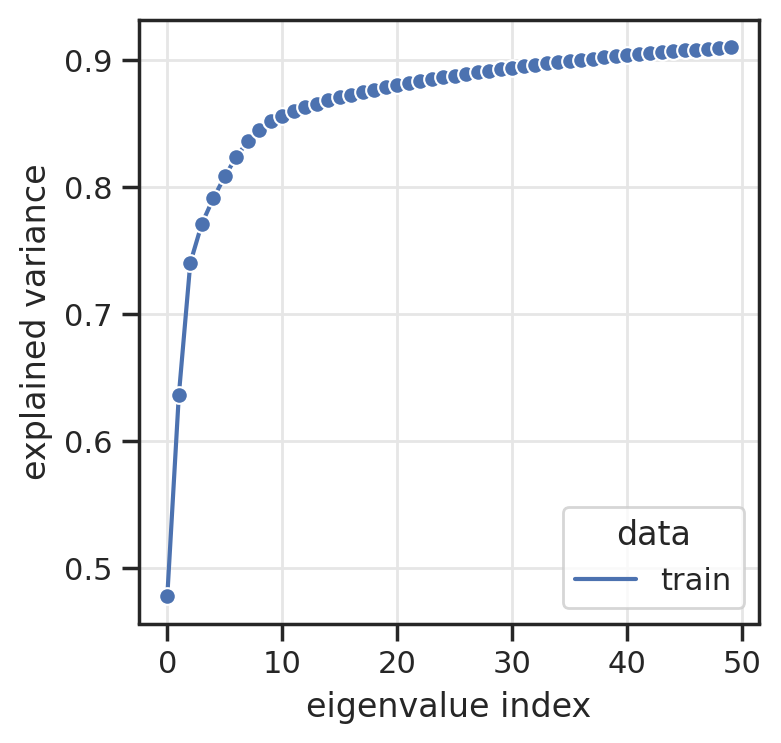

In [127]:
df = get_explained_var(r, key)
g=sns.lineplot(data=df, x='eigenvalue index', y='explained variance', hue='data', marker="o")

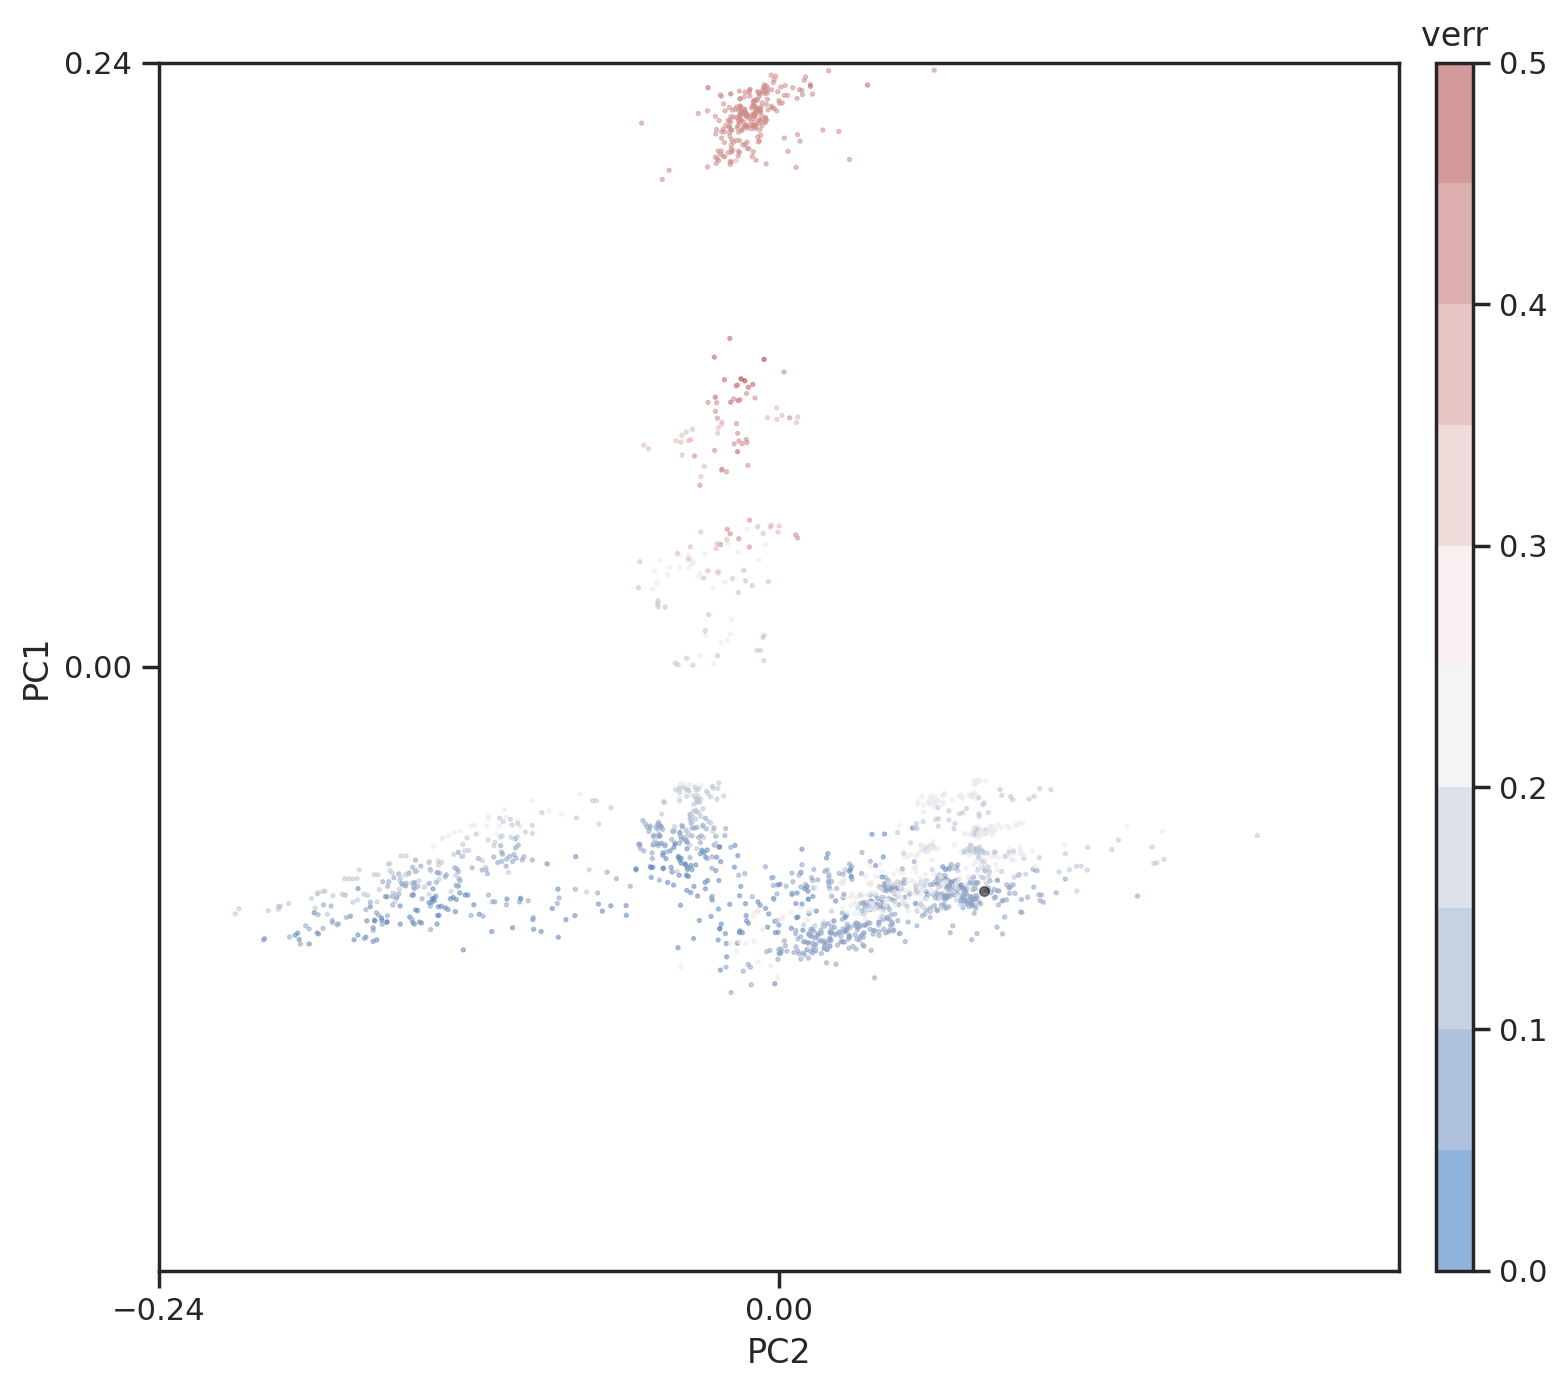

In [13]:
from utils import triplot
emph = list(didx[didx.m=='geodesic'].index)
f, gs = triplot(didx.reset_index(drop=True), r, emph={'geodesic':emph},
                    empsize={'geodesic':12}, legend=True,
                    empcolor={'geodesic':'black'}, d=4, 
                ckey='verr', colorscale='vlag',
                discrete_c=True, cbins=10, 
                cmin=0, cmax=0.5,
                grid_ratio=[4,4], grid_size=0.06, centers=[0.0, 0])

In [47]:
f.savefig('plots/traj_test.pdf', bbox_inches='tight')

In [ ]:
from utils import plotly_3d
emph = list(didx[didx.m=='geodesic'].index)
fig = plotly_3d(dc=didx.reset_index(drop=True), r=r, 
                    emph={'geodesic':emph},
                    empsize={'geodesic':6}, 
                    empcolor={'geodesic':'black'},
                    opacity=0.25,
                    colorscale='Set1',
                    ne=5, 
                    color='m',
                    cols = ['seed', 'm', 'opt', 'bs', 'aug',  'lr', 'wd'],
                    xrange=[-1, 1],
                    yrange=[-1, 1],
                    zrange=[-0.75, 0.75],
                 cdict=CDICT_M,
               )
fig.show()

### Pairwise distance plot

In [ ]:
pdists, rows, columns = plot_pairwise_dist(dists, didx[cols].round(5),
                                          tidxs=slice(99,100),
                                          sortby=[2, 1, 5, 0], 
                                          xblock_size=10, yblock_size=10, square=True, 
                                          label_idxs=slice(0,None), return_didx=True,
                                          reduction='avg_pool2d',annot=False)
# plt.figure(figsize=(12, 10))
# sns.heatmap(pd.DataFrame(pdists, index=pd.MultiIndex.from_arrays(columns.T, names=cols)),
# #             center=0.1,
#             yticklabels='auto', xticklabels=False, cmap='vlag')

## Feature Importance

In [16]:
idx=didx.groupby(cols).indices
pdists = np.zeros([100, len(idx), len(idx)])
keys = list(idx.keys())
for i in range(len(idx)):
    for j in range(i, len(idx)):
        ii = idx[keys[i]]
        jj = idx[keys[j]]
        dij = dists[:, ii, :][:, :, jj]
        pdists[:, i, j] = pdists[:, j, i] = dij.mean(axis=(1, 2))
dd = pd.DataFrame(np.array(keys, dtype="O"), columns=cols)

In [17]:
t = 100
dt = pdists[:t, :, :].sum(0) / 100
dd['d2geod'] = dt[dd[dd.m=='geodesic'].index[0], :]

ii = list(dd[dd.m!='geodesic'].index)
dd = dd.iloc[ii].reset_index(drop=True)
dt = dt[ii, :][:, ii]
dcross = dd.merge(dd, how='cross')
dcross['dcross'] = dt.ravel()

In [18]:
features = ['m', 'opt', 'bs', 'aug', 'wd']
for f in cols:
    dcross[f] = dcross[[f'{f}_x', f'{f}_y']].astype(
    str).apply(' '.join, axis=1)

In [28]:
len(dcross['dcross'].unique())

24976

In [43]:
features = features +  ['d2geod_x', 'd2geod_y', 'dcross']
dcross = dcross[features]

In [53]:
agg_fn = {f:'first' for f in features}
dcross = dcross.groupby(['dcross']).aggregate(agg_fn).reset_index(drop=True)

In [54]:
from autogluon.tabular import TabularDataset, TabularPredictor

ModuleNotFoundError: No module named 'autogluon'

In [33]:
dcross = dcross[features + ['d2geod_x', 'd2geod_y', 'dcross']]

In [34]:
train_data = TabularDataset(dcross)

In [35]:
predictor = TabularPredictor(label='dcross').fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20230402_183919/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230402_183919/"
AutoGluon Version:  0.7.0
Python Version:     3.8.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #73~18.04.1-Ubuntu SMP Mon Mar 14 18:47:48 UTC 2022
Train Data Rows:    50176
Train Data Columns: 7
Label Column: dcross
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.30687150070209773, 2.9718220233917247e-08, 0.11312, 0.03884)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Availabl

[1000]	valid_set's rmse: 0.00363616
[2000]	valid_set's rmse: 0.00309666
[3000]	valid_set's rmse: 0.00285767
[4000]	valid_set's rmse: 0.00272668
[5000]	valid_set's rmse: 0.00264451
[6000]	valid_set's rmse: 0.00258587
[7000]	valid_set's rmse: 0.00254387
[8000]	valid_set's rmse: 0.00251082
[9000]	valid_set's rmse: 0.00248838
[10000]	valid_set's rmse: 0.00246725


	-0.0025	 = Validation score   (-root_mean_squared_error)
	18.98s	 = Training   runtime
	0.5s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.00305408
[2000]	valid_set's rmse: 0.00265259
[3000]	valid_set's rmse: 0.00251733
[4000]	valid_set's rmse: 0.00245006
[5000]	valid_set's rmse: 0.00238869
[6000]	valid_set's rmse: 0.00235872
[7000]	valid_set's rmse: 0.00234023
[8000]	valid_set's rmse: 0.00232841
[9000]	valid_set's rmse: 0.00231894
[10000]	valid_set's rmse: 0.00230804


	-0.0023	 = Validation score   (-root_mean_squared_error)
	14.89s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.0044	 = Validation score   (-root_mean_squared_error)
	1.64s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: CatBoost ...
	-0.0027	 = Validation score   (-root_mean_squared_error)
	138.24s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.0052	 = Validation score   (-root_mean_squared_error)
	1.14s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.0037	 = Validation score   (-root_mean_squared_error)
	39.05s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	-0.0031	 = Validation score   (-root_mean_squared_error)
	4.04s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.0045	 = Validation score   (-root_mean_squared_error)
	70.88s	 = Training   runtime
	0.01s	 = Validation

[1000]	valid_set's rmse: 0.00280108
[2000]	valid_set's rmse: 0.00258993
[3000]	valid_set's rmse: 0.00251992
[4000]	valid_set's rmse: 0.00248096
[5000]	valid_set's rmse: 0.00246393
[6000]	valid_set's rmse: 0.00245317
[7000]	valid_set's rmse: 0.00244469
[8000]	valid_set's rmse: 0.00243854
[9000]	valid_set's rmse: 0.00243405
[10000]	valid_set's rmse: 0.00243061


	-0.0024	 = Validation score   (-root_mean_squared_error)
	45.7s	 = Training   runtime
	0.38s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.0023	 = Validation score   (-root_mean_squared_error)
	0.22s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 338.76s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230402_183919/")


In [36]:
train_importances = predictor.feature_importance(data=train_data)

Computing feature importance via permutation shuffling for 7 features using 5000 rows with 5 shuffle sets...
	102.64s	= Expected runtime (20.53s per shuffle set)
	88.36s	= Actual runtime (Completed 5 of 5 shuffle sets)


importance    stddev       p_value  n  p99_high   p99_low
m      0.033430  0.000639  1.604042e-08  5  0.034746  0.032113
bs     0.009881  0.000501  7.882184e-07  5  0.010912  0.008850
opt    0.009032  0.000486  1.005345e-06  5  0.010034  0.008031
aug    0.006221  0.000416  2.378317e-06  5  0.007077  0.005365
wd     0.004851  0.000472  1.065333e-05  5  0.005823  0.003878

[Text(0, 0.5, 'feature')]

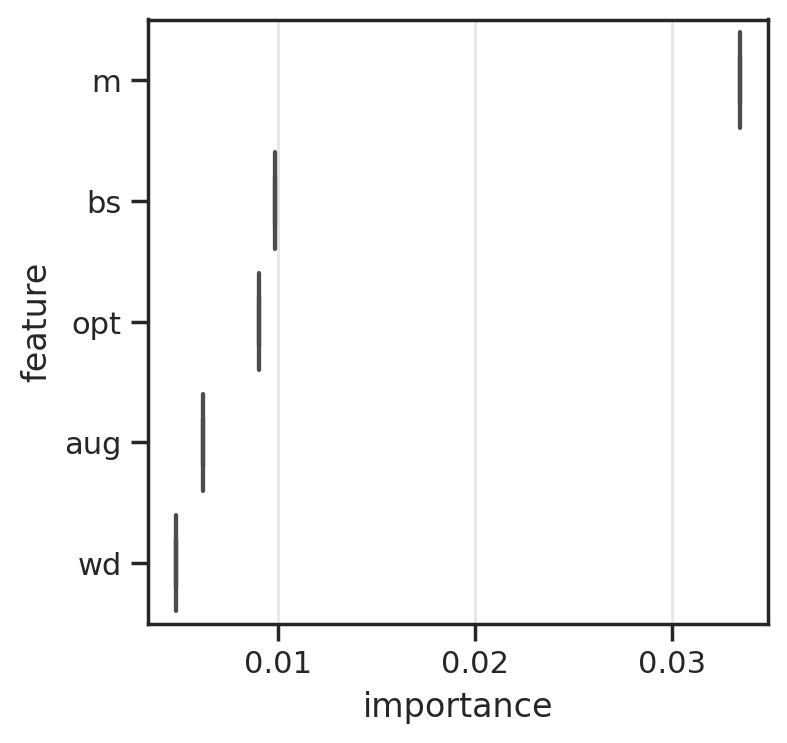

In [41]:
f, ax = plt.subplots()
sns.boxplot(data=train_importances.loc[['m', 'bs','opt','aug','wd']].reset_index(), x='importance', y='index', orient='h', ax=ax)
ax.set(ylabel='feature')

In [42]:
f.savefig('plots/feature_importance.pdf')

In [15]:
test_importances = predictor.feature_importance(data=train_data)

Computing feature importance via permutation shuffling for 7 features using 5000 rows with 5 shuffle sets...
	127.24s	= Expected runtime (25.45s per shuffle set)
	112.59s	= Actual runtime (Completed 5 of 5 shuffle sets)


In [25]:
test_importances

importance    stddev       p_value  n  p99_high   p99_low
m           0.053159  0.000880  9.019148e-09  5  0.054971  0.051346
d2geod_y    0.039531  0.000713  1.271206e-08  5  0.040999  0.038062
d2geod_x    0.039388  0.000617  7.221866e-09  5  0.040658  0.038117
bs          0.013401  0.000435  1.331031e-07  5  0.014297  0.012505
opt         0.011318  0.000464  3.377349e-07  5  0.012273  0.010363
aug         0.010132  0.000332  1.386775e-07  5  0.010816  0.009448
wd          0.005554  0.000425  4.073611e-06  5  0.006428  0.004679

<AxesSubplot:xlabel='importance', ylabel='index'>

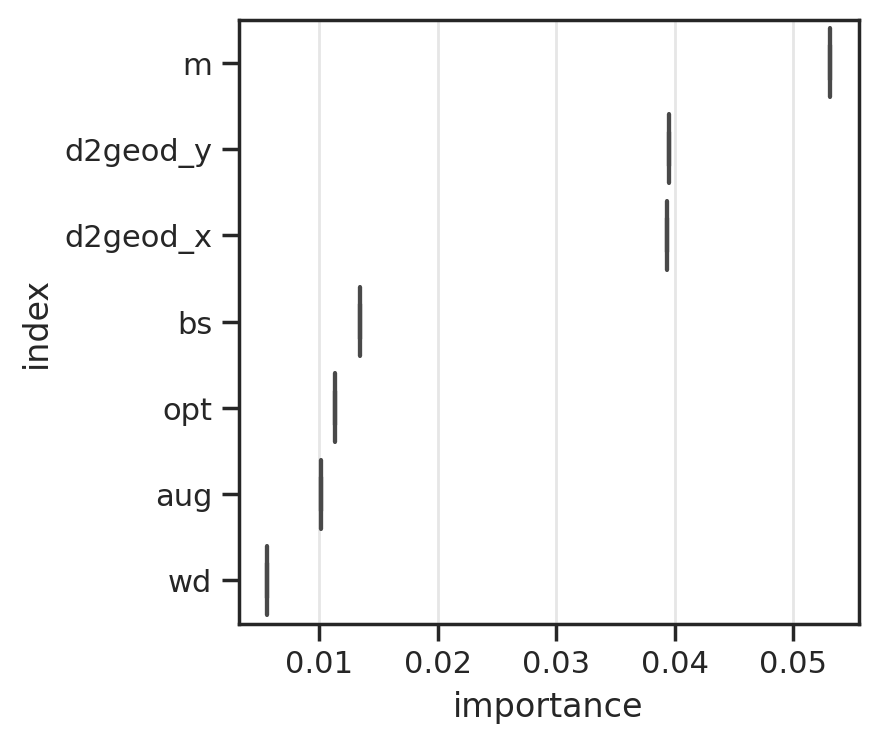

In [24]:
# data = pd.DataFrame(test_importances['importance'], columns=features + ['d2geod_x', 'd2geod_y'])

f, ax = plt.subplots()
sns.boxplot(data=test_importances.reset_index(), x='importance', y='index', orient='h', ax=ax)

### Information Gain

In [55]:
np.fill_diagonal(dt, 0)
v = squareform(dt)
linkage = sch.linkage(v, method='complete', optimal_ordering=True)

In [11]:
cluster = sch.fcluster(linkage, v.max()/3, 
                       criterion='distance')

In [ ]:
def entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    counts = counts / len(cluster)
    return -(np.log2(counts)*counts).sum()

In [ ]:
cols = ['m', 'opt', 'aug', 'bs', 'wd']
ents = []
for group in cols:
    groups = didx.groupby(group).indices
    ent = 0
    for (c, ii) in groups.items():
        ent += entropy(cluster[ii]) * len(ii)/len(didx)
    ents.append({'group':group, 'info_gain':entropy(cluster)-ent})

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(data=pd.DataFrame(ents), x='info_gain', y='group', ax=ax)

### Fitting a linear model

In [38]:
f = pd.get_dummies(didx['m']).values

In [46]:
dd = pd.DataFrame(columns, columns=cols)

In [57]:
dcross = dd.merge(dd, how='cross')
dcross['dcross'] = dt.ravel()

In [34]:
features = ['m', 'opt', 'aug', 'bs', 'wd']
X = []
for f in features:
    f = pd.get_dummies(didx[f]).values
    X.append(f@f.T)
X = np.stack(X).reshape([len(features), -1]).T
dt = dt.reshape([1, -1]).ravel()

In [35]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import RidgeCV
model = RidgeCV()
model.fit(X, dt)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

### Permutation Importance

In [107]:
from sklearn.inspection import permutation_importance
permImp = permutation_importance(model, x, dcross['dcross'], n_repeats=100, 
                              random_state=0)

In [113]:
features = np.array(features + ['d2geod_x', 'd2geod_y'])

In [114]:
data = pd.DataFrame(permImp['importances'].T, columns=features)

<AxesSubplot:>

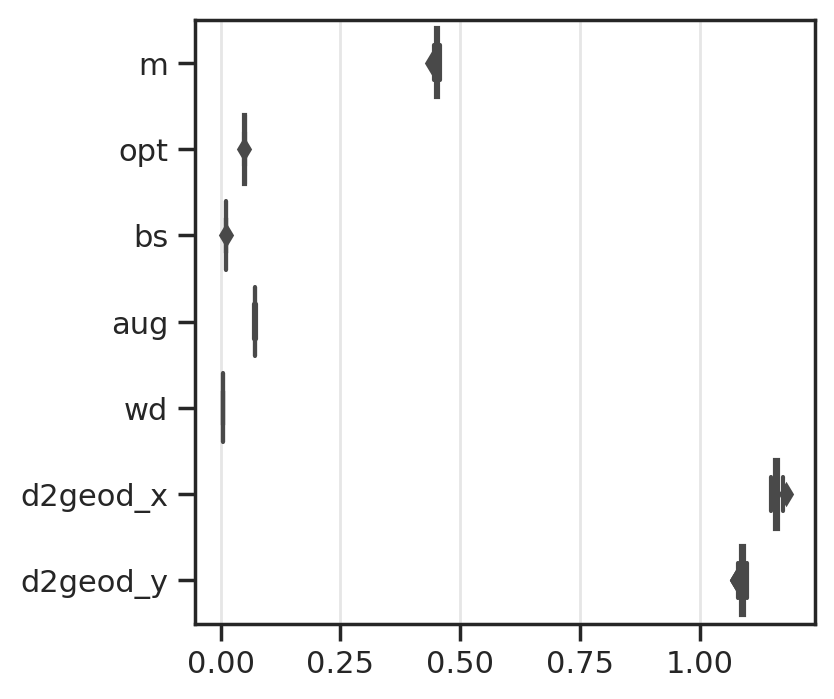

In [117]:
data = pd.DataFrame(permImp['importances'].T, columns=features)

f, ax = plt.subplots()
indices = permImp['importances_mean'].argsort()
sns.boxplot(data=data, orient='h', ax=ax)
# ax.set(xlim=(-0.02, 0.35))
# sns.boxplot(data=permImp, orient='h')

In [118]:
f.savefig('plots/train_feature_permutation_importance.pdf')

### Cross validated ridge regression

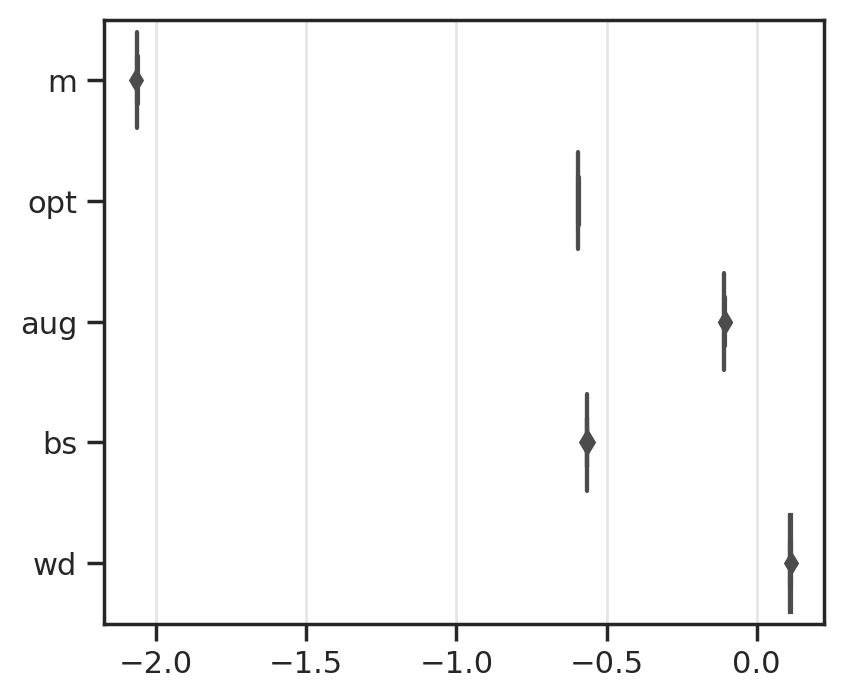

In [56]:
cv_model = cross_validate(
   model, X, dt, cv=RepeatedKFold(n_splits=15, n_repeats=15),
   return_estimator=True, n_jobs=2
)
coefs = pd.DataFrame(
   [model.coef_[0]
    for model in cv_model['estimator']],
   columns=features
)
plt.figure(figsize=(6,4))
sns.boxplot(data=coefs, orient='h')
plt.subplots_adjust(left=.3)

### Random Forest

In [100]:
features = ['m', 'opt', 'bs', 'aug', 'wd']

In [101]:
for f in cols:
    dcross[f] = dcross[[f'{f}_x', f'{f}_y']].astype(str).apply(' '.join, axis=1)

In [102]:
from sklearn.preprocessing import LabelEncoder
for f in features:
    le = LabelEncoder()
    dcross[f] = le.fit_transform(dcross[f])

In [103]:
x = np.stack(dcross[features+['d2geod_x', 'd2geod_y']].values)

In [104]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(x, dcross['dcross'])
model.score(x, dcross['dcross'])

0.9975906574897427

In [105]:
importances = model.feature_importances_

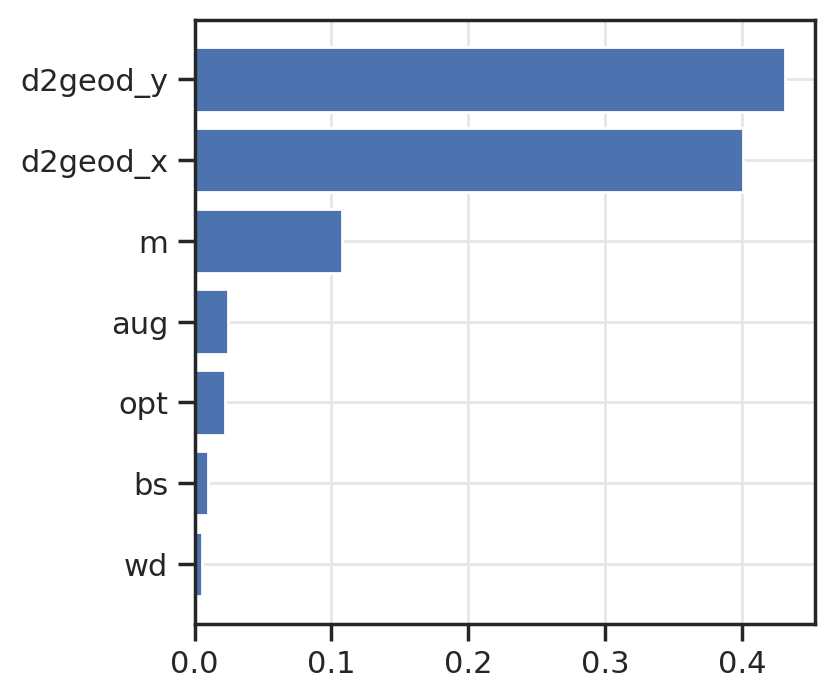

In [106]:
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(features + ['d2geod_x', 'd2geod_y'])[indices])

#### RF permutation importance

In [ ]:
from sklearn.inspection import permutation_importance
permImp = permutation_importance(model, x, dcross['dcross'], n_repeats=100, 
                              random_state=0)

In [ ]:
data = pd.DataFrame(permImp['importances'].T, columns=features)
f, ax = plt.subplots()
indices = permImp['importances_mean'].argsort()
sns.boxplot(data=data, orient='h', ax=ax)
ax.set(xlim=(-0.02, 0.35))
# sns.boxplot(data=permImp, orient='h')

### Dendrogram Prep

In [ ]:
pdists, rows, columns = plot_pairwise_dist(dists, didx[cols].round(5),
                                          tidxs=slice(50, 51),
                                          sortby=[2, 1, 4, 0], 
                                          xblock_size=10, yblock_size=10, square=True, 
                                          label_idxs=slice(0,None), return_didx=True,
                                          reduction='avg_pool2d',annot=False)

linkage, cluster, sorted_dists = cluster_corr(pdists)

In [ ]:
columns = np.hstack([columns, (columns[:,2].astype('float') / columns[:,3].astype('float')).astype('str')[:, None]])

In [ ]:
from bokeh import palettes
import matplotlib.colors as mcolors

label_by = 0
cs_ = columns[:, :6]
cs = ['.'.join(l) for l in cs_]

ccol = didx[cols[label_by]]
colors = palettes.Set1[max(len(ccol.unique()), 3)]
cdict = {c: mcolors.to_rgba(colors[i]) for (i, c) in enumerate(ccol.unique())}

### Training, end of training

In [ ]:
fig, ax=plot_dendrogram(linkage, cs_, cdict, didx)

In [ ]:
idxs = didx.groupby(cols).indices
fig, ax = plt.subplots(1, 2, figsize =(10, 16))

dend = sch.dendrogram(linkage, orientation='right', no_plot=True, color_threshold=0.01)
label_colors = [cdict[m] for m in cs_[dend['leaves'], label_by]]
dend = sch.dendrogram(linkage, orientation='right', labels=np.array(cs_[:, 0]), color_threshold=0, ax=ax[0])

# barplot of errors
vkey = 'verr' if key =='yvh' else 'err'
err = []
for c in cs_[dend['leaves'][::-1], :]:
    m, opt = c[:2] 
    bs = int(c[2])
    aug = c[-1]
    lr = float(c[3])
    wd = float(c[4])
    err.append(didx.iloc[idxs[(m, opt, bs, lr, wd, aug)]][vkey].mean())
    
models = np.array(cs)[dend['leaves'][::-1]]
data = pd.DataFrame(np.vstack([models, err]).T, columns=['model', 'err'])
data['err'] = data['err'].astype(float)

barc = [cdict[m.split('.')[label_by]] for m in models]
sns.barplot(x="err", y="model", data=data, ax=ax[1], palette=barc).set(yticklabels=[], ylabel="")
ax[1].set_xlim([0, 1])
ax[1].invert_xaxis()
ax[1].yaxis.set_ticks_position('none')
ax[1].grid(axis='y')


yax = ax[0].get_yaxis()
r = yax.set_tick_params(pad=75)
for (ik, k) in enumerate([1, 2, 4, 5]):
    secax = ax[0].secondary_yaxis('left')
    secax.set_yticks(ax[0].get_yticks())
    secax.set_yticklabels(cs_[dend['leaves'], k])
    secax.get_yaxis().set_tick_params(pad=75-(ik+1)*18, labelsize=5, length=0)
    for (n, y) in enumerate(secax.get_ymajorticklabels()):
        y.set_color(label_colors[n])

plt.subplots_adjust(wspace=0)
for x in ax[0].get_ymajorticklabels():
    x.set_color(cdict[x.get_text().split(' ')[label_by]])
    

In [ ]:
fig.savefig(f'plots/{key}_dend_0.5.pdf', bbox_inches='tight')  

### Validation, end of training

In [ ]:
idxs = didx.groupby(cols).indices
fig, ax = plt.subplots(1, 2, figsize =(10, 16))
dend = sch.dendrogram(linkage, orientation='right', labels=cs, ax=ax[0], color_threshold=1e-5)

err = []
for c in cs_[dend['leaves'][::-1], :]:
    m, opt = c[:2] 
    bs = int(c[2])
    aug = c[-1]
    lr = float(c[3])
    wd = float(c[4])
    err.append(didx.iloc[idxs[(m, opt, bs, lr, wd, aug)]].verr.mean())
    
models = np.array(cs)[dend['leaves'][::-1]]
data = pd.DataFrame(np.vstack([models, err]).T, columns=['model', 'err'])
data['err'] = data['err'].astype(float)

barc = [cdict[m.split('.')[label_by]] for m in models]
sns.barplot(x="err", y="model", data=data, ax=ax[1], palette=barc).set(yticklabels=[], ylabel="")
ax[1].set_xlim([0, 1])
ax[1].invert_xaxis()
ax[1].yaxis.set_ticks_position('none')
ax[1].grid(axis='y')

plt.subplots_adjust(wspace=0)
# ax = plt.gca()
for x in ax[0].get_ymajorticklabels():
    x.set_color(cdict[x.get_text().split('.')[label_by]])

### Training

In [ ]:
plt.figure(figsize=(8, 16))
dend = sch.dendrogram(linkage, orientation='right', labels=cs, color_threshold=6)

ax = plt.gca()
for x in ax.get_ymajorticklabels():
    x.set_color(cdict[x.get_text().split('.')[label_by]])

### time evolution

In [ ]:
i = 25
di = []
for t in range(100):
    pdists, rows, columns = plot_pairwise_dist(dists, didx[cols].round(5),
                                          tidxs=slice(t,t+1),
                                          sortby=[0], 
                                          xblock_size=10, yblock_size=10, square=True, 
                                          label_idxs=slice(0,None), return_didx=True,
                                          reduction='avg_pool2d',annot=False)
    di.append(pdists[:, i])
di = np.stack(di)

In [ ]:
df = pd.DataFrame(rows, columns=cols)
df['d2ref'] = np.array_split(di.T, len(df))

In [ ]:
df = df.explode('d2ref').explode('d2ref')
df['progress'] = np.tile(np.linspace(0, 1, 100), len(di.T))
df = df.reset_index(drop=True)

In [ ]:
df.loc[(df[cols]==rows[i]).all(axis=1),'d2ref'] *= 10/9

In [ ]:
sns.lineplot(data=df[(df[['m', 'aug']]==['allcnn', 'none']).all(axis=1)], x='progress', y='d2ref', hue='opt', style='bs')
sns.lineplot(data=df[(df[cols]==rows[i]).all(axis=1)], 
            x='progress', y='d2ref', label=rows[i], color='black')

In [ ]:
n = len(rows)
diag = np.diag(pdists)
diag = diag*100/90
pdists[np.eye(n).astype(bool)] = diag
pdists = pdists / diag

fig = px.imshow(pdists, x=cs, y=rs, color_continuous_scale='RdBu_r')
axis_template = dict(showticklabels = False, ticks = '' )
fig.update_layout(
    xaxis = axis_template,
    yaxis = axis_template,
    showlegend = False,
    width = 800, height = 800)
fig.show()

In [ ]:
cols = ['seed', 'm', 'opt', 'bs','lr', 'wd','err','aug']
didxs, rows, columns = plot_pairwise_dist(dist, didx[cols].round(5), 
    cconds=[lambda x: x[0] > 0.0 and x[1] not in ['fc', 'vit']],
    sortby=[4, 5, 2, 3, 1], xblock_size=10, yblock_size=10, square=True, label_idxs=slice(0,-1), return_didx=True,
    reduction='avg_pool2d',annot=False)
cs = ['-'.join(l) for l in columns]

rs = ['-'.join(l) for l in rows]

fig = px.imshow(didxs, x=cs, y=rs, color_continuous_scale='RdBu_r', origin='lower')
axis_template = dict(showticklabels = False, ticks = '' )
fig.update_layout(
    xaxis = axis_template,
    yaxis = axis_template,
    showlegend = False,
    width = 800, height = 800)
fig.show()

In [ ]:
cols = ['seed', 'm', 'opt', 'bs','lr', 'wd','err','aug']
didxs, rows, columns = plot_pairwise_dist(dist, didx[cols].round(5), 
    cconds=[lambda x: x[0] == -1 and x[1] not in ['fc', 'vit']],
    sortby=[4, 5, 2, 3, 1], xblock_size=1, yblock_size=1, square=True, label_idxs=slice(0,-1), return_didx=True,
    reduction='',annot=False)
cs = ['-'.join(l) for l in columns]
rs = ['-'.join(l) for l in rows]

fig = px.imshow(didxs, x=cs, y=rs, color_continuous_scale='RdBu_r', origin='lower')
axis_template = dict(showticklabels = False, ticks = '' )
fig.update_layout(
    xaxis = axis_template,
    yaxis = axis_template,
    showlegend = False,
    width = 800, height = 800)
fig.show()

### 3d tensor

In [ ]:
key = 'yh'
didx = th.load(f"{root}/inpca/inpca_results_avg_new/didx_3d_{key}.p").reset_index(drop=True)
dists = th.load(f"{root}/inpca/inpca_results_avg_new/dists_3d_{key}.p")

In [ ]:
idx = get_idx(didx, "err < 0.1 and seed > 0")
didx = didx.iloc[idx].reset_index(drop=True)
dists = dists[:, :, idx][:, idx, :]

In [ ]:
ts = [0, 1, 10, 50, 90]
dt = np.zeros([(len(ts)-1)*len(didx), (len(ts)-1)*len(didx)])
for (i, t) in enumerate(ts):
    for j in range(i+1, len(ts)):
        w = dists[ts[i]:ts[j], :, :]
        dt[i*len(didx):(i+1)*len(didx), (j-1)*len(didx):j*len(didx)] = w.mean(0)
        dt[(j-1)*len(didx):j*len(didx), i*len(didx):(i+1)*len(didx)] = w.mean(0).T

In [ ]:
w = dt
l = np.eye(w.shape[0]) - 1.0/w.shape[0]
w = -l @ w @ l / 2
r = proj_(w, w.shape[0], 50)

In [ ]:
d = None
for i in range(len(ts)-1):
    d_ = didx
    d_['t'] = ts[i+1]
    d = pd.concat([d, d_])
for i in range(7):
    d[f'x{i}'] = r['xp'][:, i]

In [ ]:
figs, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
for i in range(4):
    t = ts[i+1]
    legend=(t==10)
    ax = axs[i//2, i%2]
    sns.scatterplot(data=d[d.t==t].reset_index(drop=True),  x='x0', y='x1', hue='m', style='opt', legend=legend,
                   ax=ax)
    ax.set_title(f"t = {t}")
    ax.set_xlim([-0.5, 0.5])
    ax.set_ylim([-0.5, 0.5])
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(f"validation")

In [ ]:
figs, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
for i in range(4):
    t = ts[i+1]
    legend=(t==10)
    ax = axs[i//2, i%2]
    sns.scatterplot(data=d[d.t==t].reset_index(drop=True),  x='x0', y='x1', hue='m', style='opt', legend=legend,
                   ax=ax)
    ax.set_title(f"t = {t}")
    ax.set_xlim([-0.5, 0.5])
    ax.set_ylim([-0.5, 0.5])
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('training')

In [ ]:
r['fn'] = np.linalg.norm(w, 'fro')

In [ ]:
es = r['e']
df = pd.DataFrame(dict(eval_idx=np.arange(len(es)), explained_variance=1 - np.sqrt(1-np.cumsum(es ** 2)/r['fn']**2)))
plt.figure(figsize=(8,6))
g=sns.lineplot(data=df, x='eval_idx', y='explained_variance', marker="o")

### avg_models

In [ ]:
seed = -1
m = 'allcnn'

In [ ]:
w = th.load(f"/home/ubuntu/ext_vol/inpca/inpca_results_avg_new/w_yh_({seed}, '{m}').p")
didx = th.load(f"/home/ubuntu/ext_vol/inpca/inpca_results_avg_new/didx_yh_({seed}, '{m}').p")

In [ ]:
w = w[:-100, :-100]
didx = didx.iloc[:-100]

In [ ]:
ne=3
n = w.shape[0]
l = np.eye(n) - 1.0/n
w = -l @ w @ l / 2
r = proj_(w, n, ne)
print(r['e'])

In [ ]:
for i in range(7):
    didx[f"x{i+1}"] = r['xp'][:, i]

In [ ]:
import plotly.express as px
axis_range = [-0.5, 0.5]
fig=px.scatter_3d(didx, x='x1', y='x2', z='x3', color='opt', symbol='bs')
fig.update_traces(marker_size = 2)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    scene_xaxis_range=axis_range,
scene_yaxis_range=axis_range,
scene_zaxis_range=axis_range,
scene_aspectmode='cube')

In [ ]:
es = r['e']
df = pd.DataFrame(dict(eval_idx=np.arange(len(es)), explained_variance=1 - np.sqrt(1-np.cumsum(es ** 2)/np.linalg.norm(w, 'fro')**2)))
plt.figure(figsize=(8,6))
g=sns.lineplot(data=df, x='eval_idx', y='explained_variance', marker="o")

### Tubes -- plots

In [146]:
didx = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_avg_new/didx_3d_yh.p').reset_index(drop=True)

In [147]:
dists = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_avg_new/dists_3d_yh.p')

In [153]:
idx = didx[didx.seed >=0].index
didx = didx.iloc[idx].reset_index(drop=True)
dists = dists[:, :, idx][:, idx, :]

idx = didx[didx.err<=0.1].index
didx = didx.iloc[idx].reset_index(drop=True)
dists = dists[:, :, idx][:, idx, :]

In [154]:
geod_idx = list(didx[didx.m == 'geodesic'].index)

In [161]:
key = 'bs'
choices = [200]
idx = list(didx[didx[key].isin(choices)].index) + geod_idx
d = didx.iloc[idx].reset_index(drop=True)
d = d[d.m != 'geodesic'].reset_index(drop=True)
w = dists[:, :, idx][:, idx, :]

In [162]:
dist2geod = w[:, :-1, -1].T
d['dist_to_geod'] = np.array_split(dist2geod, len(d))
d = d.explode('dist_to_geod').explode('dist_to_geod')
d['t'] = np.tile(np.arange(100), len(dist2geod))

### Validation data

Text(0.5, 1.0, 'bs=[200]')

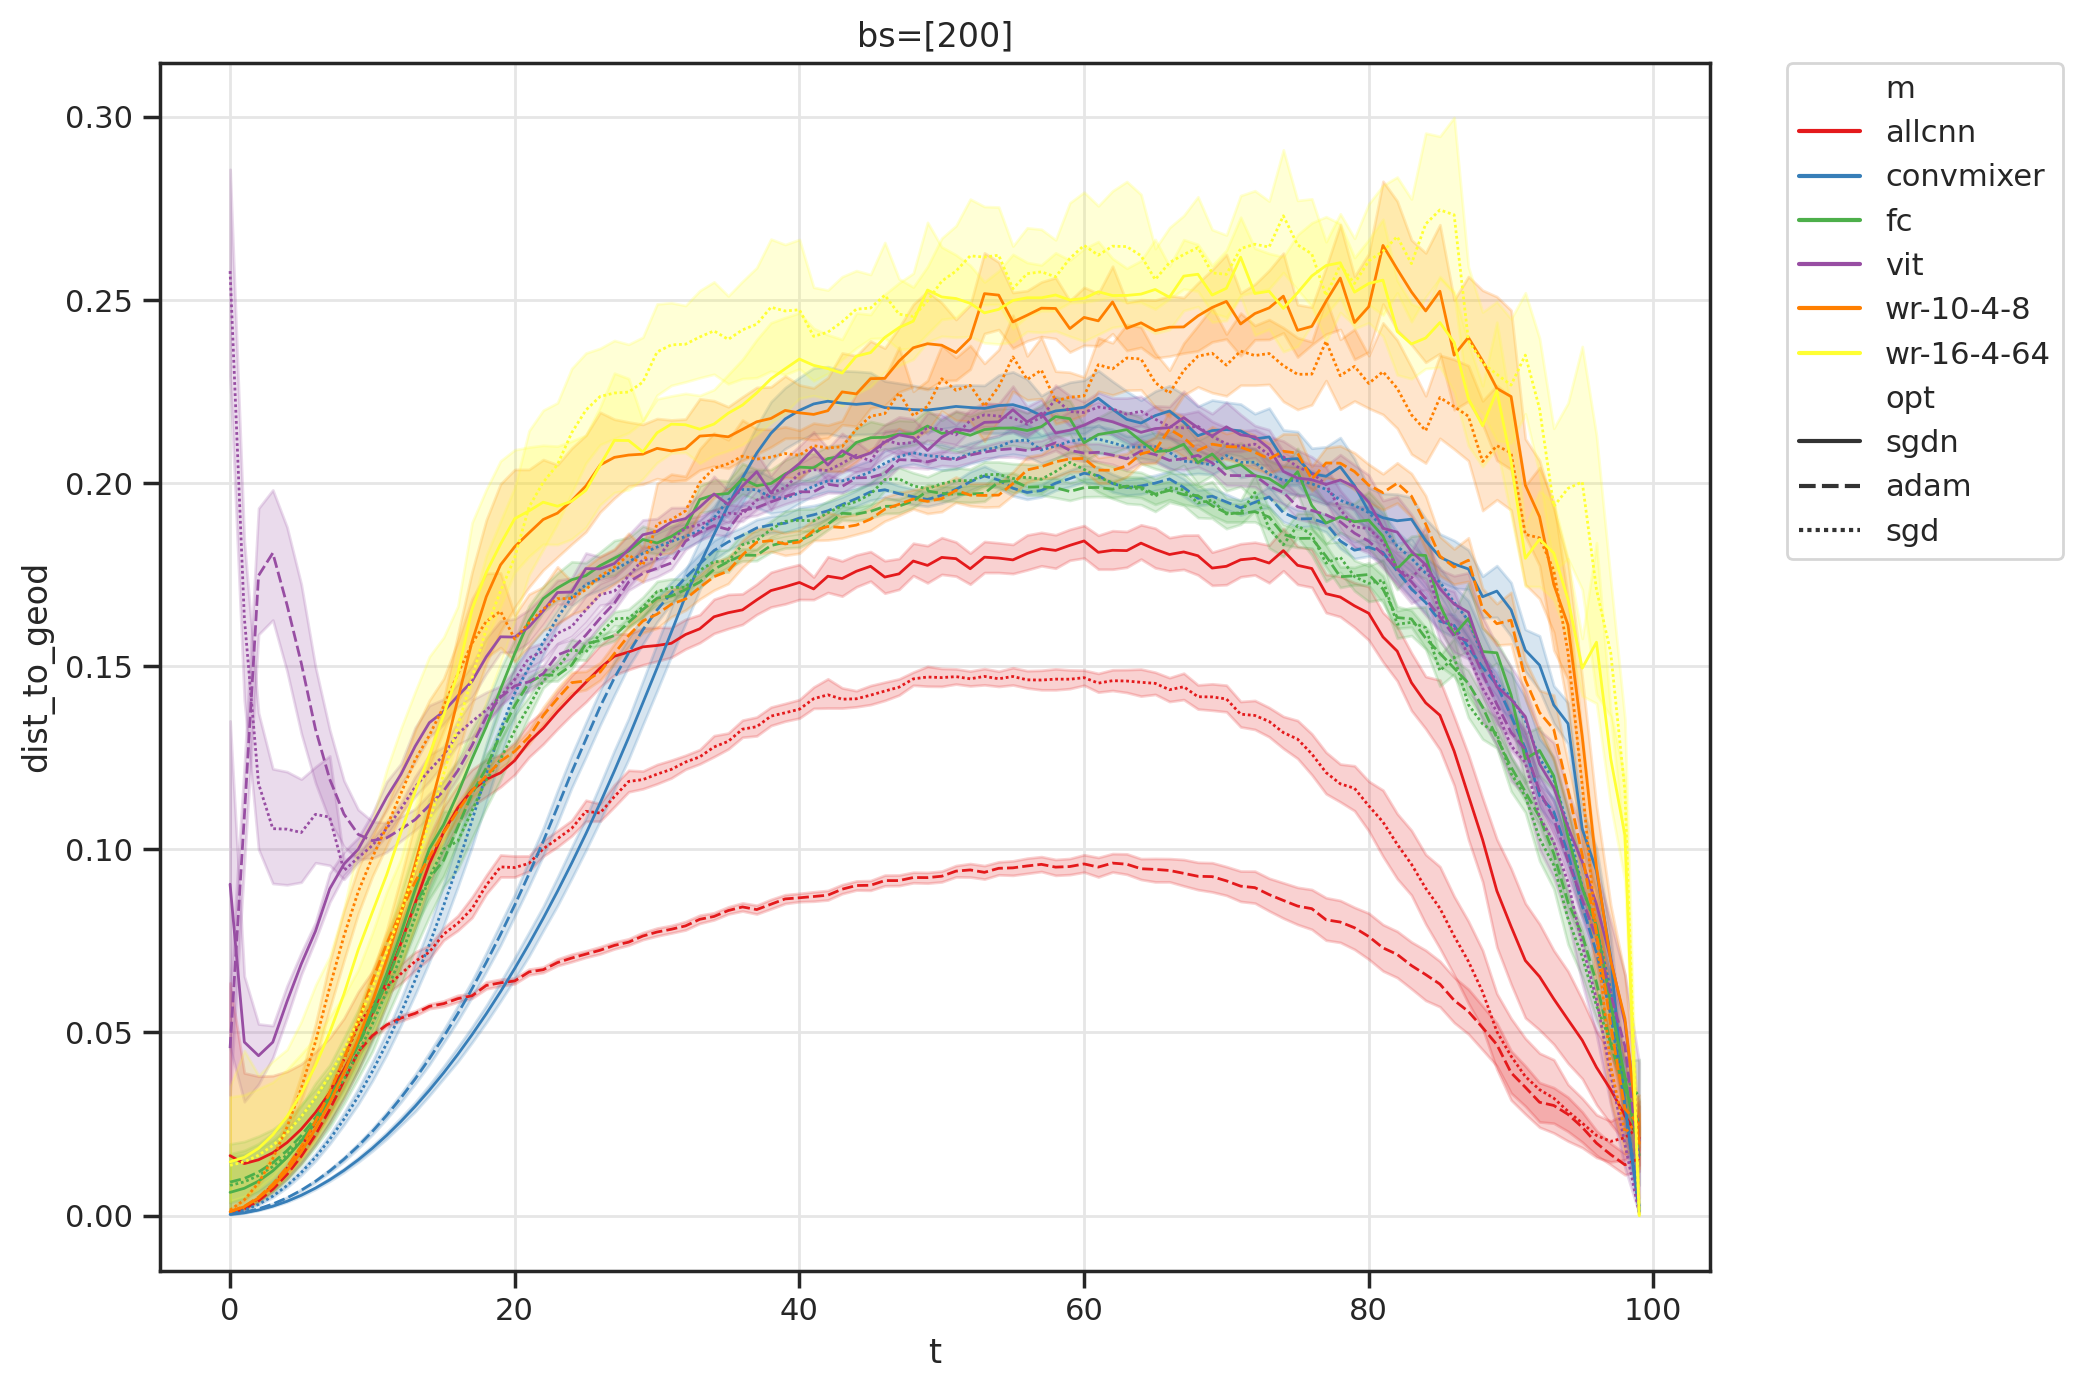

In [164]:
plt.figure(figsize=(10,8))
f = sns.lineplot(data=d[d.seed>0].reset_index(), x='t', y='dist_to_geod', hue='m', style='opt', lw=1, palette=CDICT_M)
# f = sns.lineplot(data=d[d.seed==-2].reset_index(), x='t', y='d2geod', hue='m', style='opt', lw=3, legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(f"{key}={choices}")

In [ ]:
plt.figure(figsize=(10,8))
f = sns.lineplot(data=d[d.seed>0].reset_index(), x='t', y='dist_to_geod', hue='opt', style='bs', lw=1)
# f = sns.lineplot(data=d[d.seed==-2].reset_index(), x='t', y='d2geod', hue='m', style='opt', lw=3, legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(model)

In [ ]:
plt.figure(figsize=(10,8))
f = sns.lineplot(data=d[d.seed>0].reset_index(), x='t', y='dist_to_geod', hue='opt', style='bs', lw=1)
# f = sns.lineplot(data=d[d.seed==-2].reset_index(), x='t', y='d2geod', hue='m', style='opt', lw=3, legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(model)

### Training data

In [ ]:
plt.figure(figsize=(10,8))
f = sns.lineplot(data=d[d.seed>0].reset_index(), x='t', y='dist_to_geod', hue='m', style='opt', lw=1)
# f = sns.lineplot(data=d[d.seed==-2].reset_index(), x='t', y='d2geod', hue='m', style='opt', lw=3, legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(f"{key}={choices}")

In [ ]:
plt.figure(figsize=(10,8))
f = sns.lineplot(data=d[d.seed>0].reset_index(), x='t', y='dist_to_geod', hue='opt', style='bs', lw=1)
# f = sns.lineplot(data=d[d.seed==-2].reset_index(), x='t', y='d2geod', hue='m', style='opt', lw=3, legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(model)

In [ ]:
plt.figure(figsize=(10,8))
f = sns.lineplot(data=d[d.seed>0].reset_index(), x='t', y='dist_to_geod', hue='opt', style='bs', lw=1)
# f = sns.lineplot(data=d[d.seed==-2].reset_index(), x='t', y='d2geod', hue='m', style='opt', lw=3, legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(model)

In [ ]:
plt.figure(figsize=(10,8))
f = sns.lineplot(data=d[d.opt!='adam'].reset_index(), x='t', y='dist_to_geod', hue='opt', style='m', lw=1)
# f = sns.lineplot(data=d[d.seed==-2].reset_index(), x='t', y='d2geod', hue='m', style='opt', lw=3, legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(model)

In [ ]:
plt.figure(figsize=(10,8))
f = sns.lineplot(data=d.reset_index(), x='t', y='dist_to_geod', hue='opt', style='bs', lw=1)
# f = sns.lineplot(data=d[d.seed==-2].reset_index(), x='t', y='d2geod', hue='m', style='opt', lw=3, legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(model)